<a href="https://colab.research.google.com/github/FaisalGh04/SMS-GAN/blob/main/gans2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


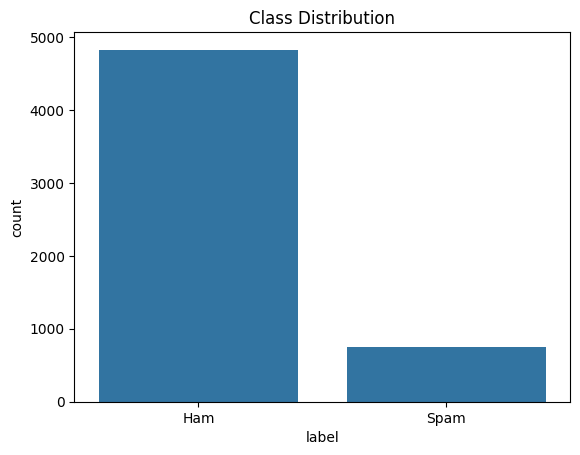

Epoch 0: D Loss: 1.1252, G Loss: 1.0052
Epoch 10: D Loss: 0.6698, G Loss: 1.8114
Epoch 20: D Loss: 0.9081, G Loss: 0.9374
Epoch 30: D Loss: 0.9899, G Loss: 0.8793
Epoch 40: D Loss: 0.8658, G Loss: 0.9649
[CGAN] Epoch 0: D Loss: 1.0676, G Loss: 1.0829
[CGAN] Epoch 10: D Loss: 0.6629, G Loss: 1.4456
[CGAN] Epoch 20: D Loss: 1.0442, G Loss: 0.8506
[CGAN] Epoch 30: D Loss: 1.1233, G Loss: 0.8774
[CGAN] Epoch 40: D Loss: 0.9712, G Loss: 0.9701
[WGAN] Epoch 0: D Loss: -0.1864, G Loss: 0.1975
[WGAN] Epoch 10: D Loss: -0.2664, G Loss: 0.2744
[WGAN] Epoch 20: D Loss: -0.1538, G Loss: 0.1625
[WGAN] Epoch 30: D Loss: -0.0741, G Loss: 0.0811
[WGAN] Epoch 40: D Loss: -0.0372, G Loss: 0.0439


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Original Dataset Results:
{'MLP': {'AUC-ROC': np.float64(0.9827976711548349),
         'Confusion Matrix': array([[955,  11],
       [ 11, 138]]),
         'F1': 0.9261744966442953,
         'Recall': 0.9261744966442953},
 'Random Forest': {'AUC-ROC': np.float64(0.9826552447649617),
                   'Confusion Matrix': array([[964,   2],
       [ 20, 129]]),
                   'F1': 0.9214285714285714,
                   'Recall': 0.8657718120805369},
 'SVM': {'AUC-ROC': np.float64(0.9877652257284589),
         'Confusion Matrix': array([[966,   0],
       [ 16, 133]]),
         'F1': 0.9432624113475178,
         'Recall': 0.8926174496644296}}

Vanilla GAN Augmented Results:
{'MLP': {'AUC-ROC': np.float64(0.987327525115678),
         'Confusion Matrix': array([[956,  10],
       [ 11, 138]]),
         'F1': 0.9292929292929293,
         'Recall': 0.9261744966442953},
 'Random Forest': {'AUC-ROC': np.float64(0.9840517181485959),
                   'Confusion Matrix': array([[964,   2],

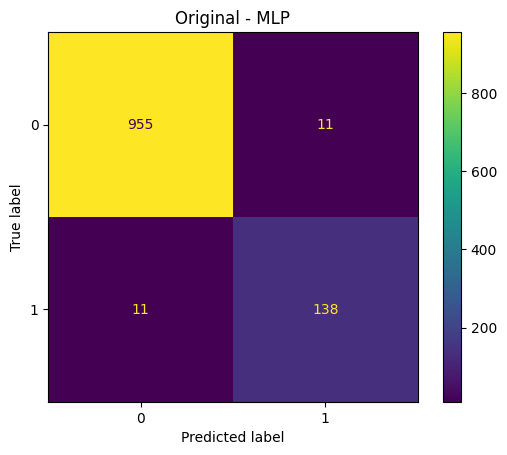


SVM:


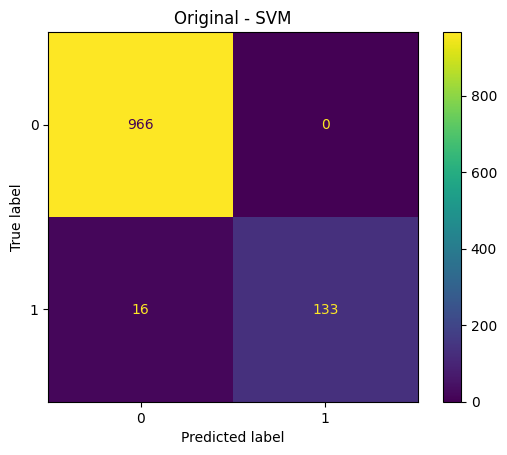


Random Forest:


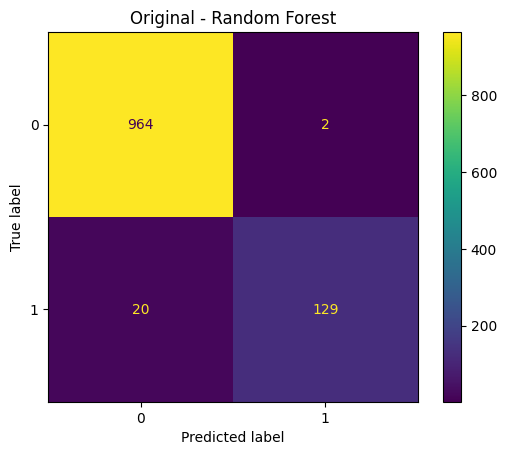


Confusion Matrices for Vanilla GAN Dataset

MLP:


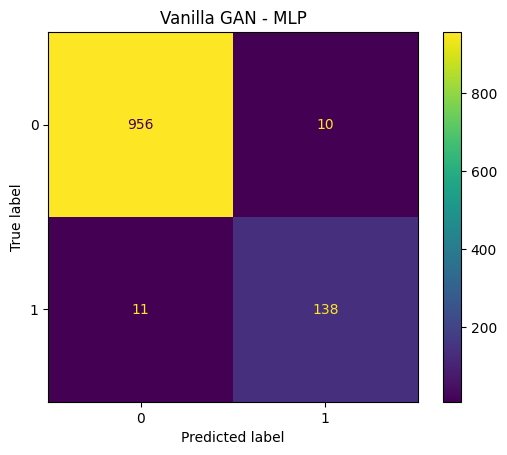


SVM:


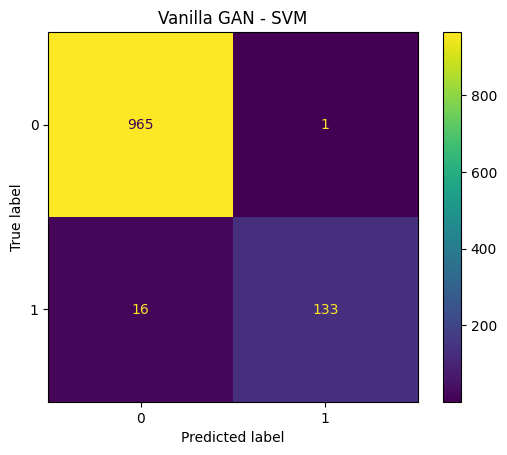


Random Forest:


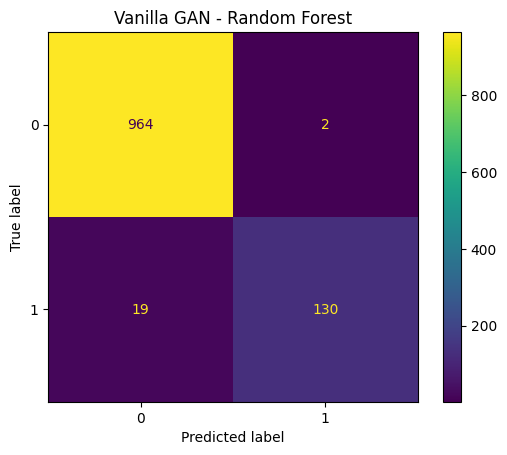


Confusion Matrices for CGAN Dataset

MLP:


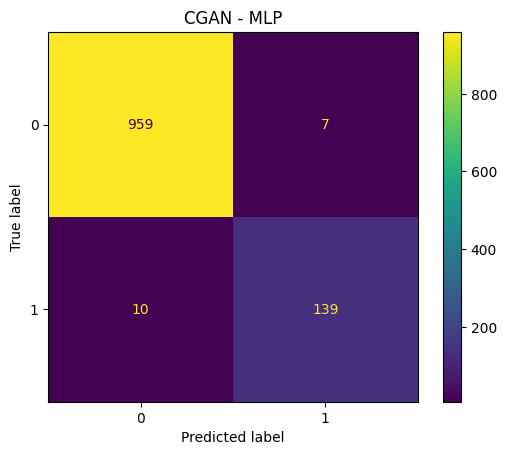


SVM:


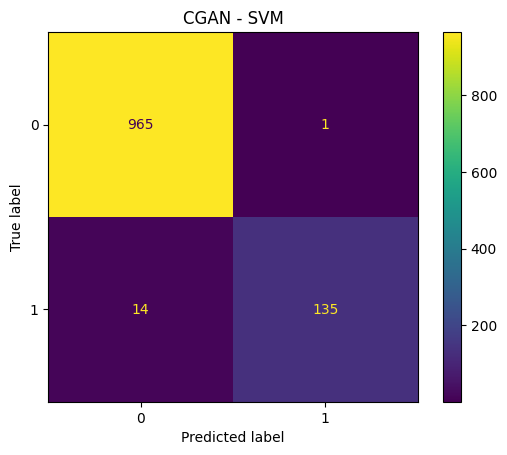


Random Forest:


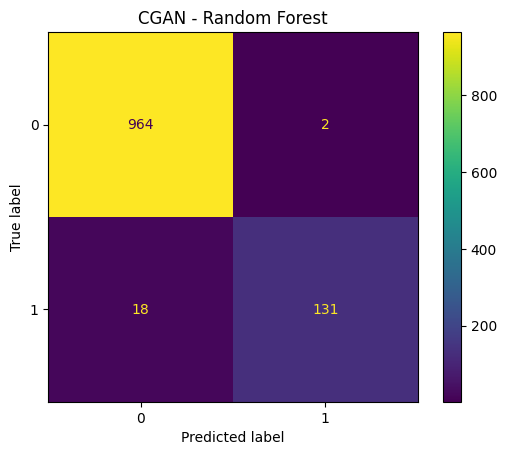


Confusion Matrices for WGAN Dataset

MLP:


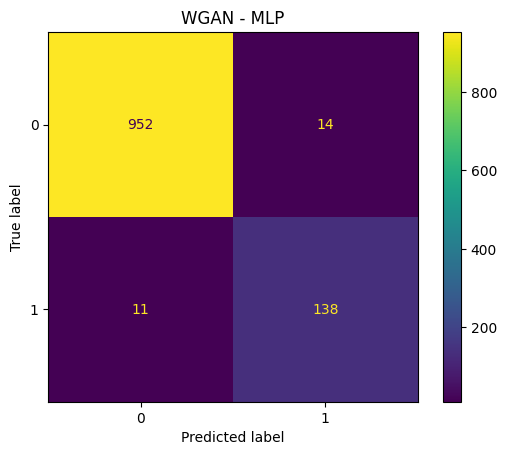


SVM:


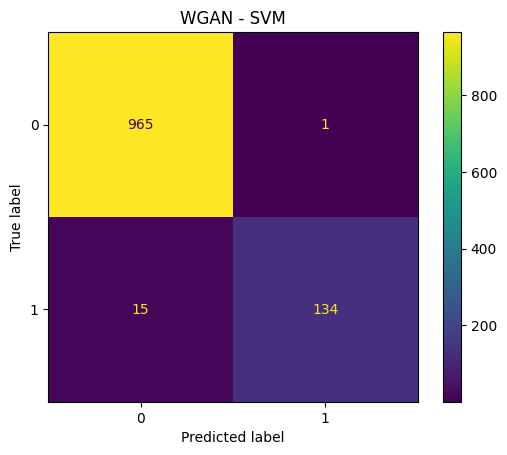


Random Forest:


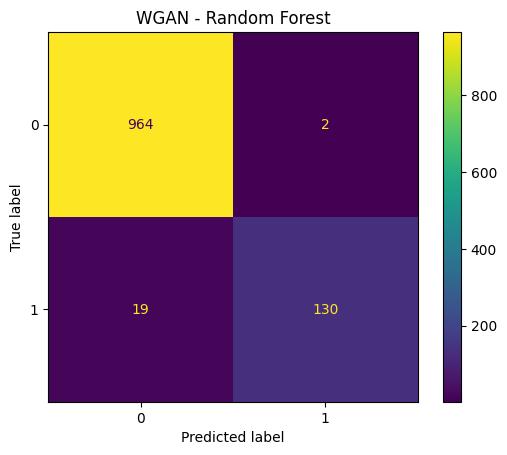

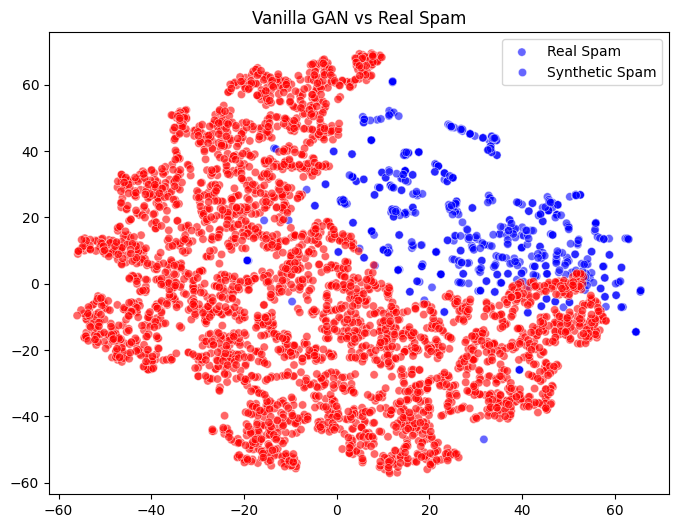

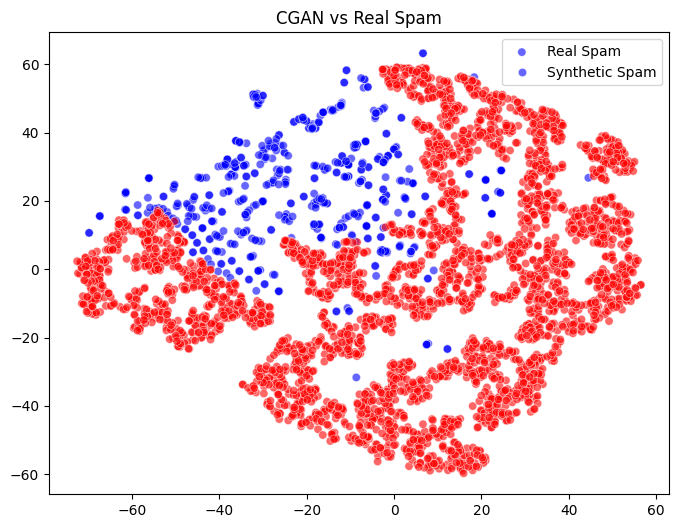

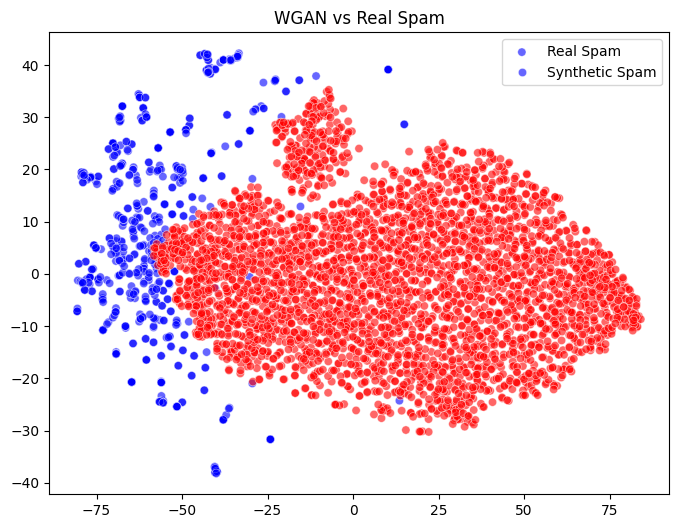


Summary Table of Model Performance:
        Dataset          Model        F1    Recall   AUC-ROC
0      Original            MLP  0.926174  0.926174  0.982798
1      Original            SVM  0.943262  0.892617  0.987765
2      Original  Random Forest  0.921429  0.865772  0.982655
3   Vanilla GAN            MLP  0.929293  0.926174  0.987328
4   Vanilla GAN            SVM  0.939929  0.892617  0.992510
5   Vanilla GAN  Random Forest  0.925267  0.872483  0.984052
6          CGAN            MLP  0.942373  0.932886  0.987647
7          CGAN            SVM  0.947368  0.906040  0.992323
8          CGAN  Random Forest  0.929078  0.879195  0.983204
9          WGAN            MLP  0.916944  0.926174  0.985292
10         WGAN            SVM  0.943662  0.899329  0.991989
11         WGAN  Random Forest  0.925267  0.872483  0.982763


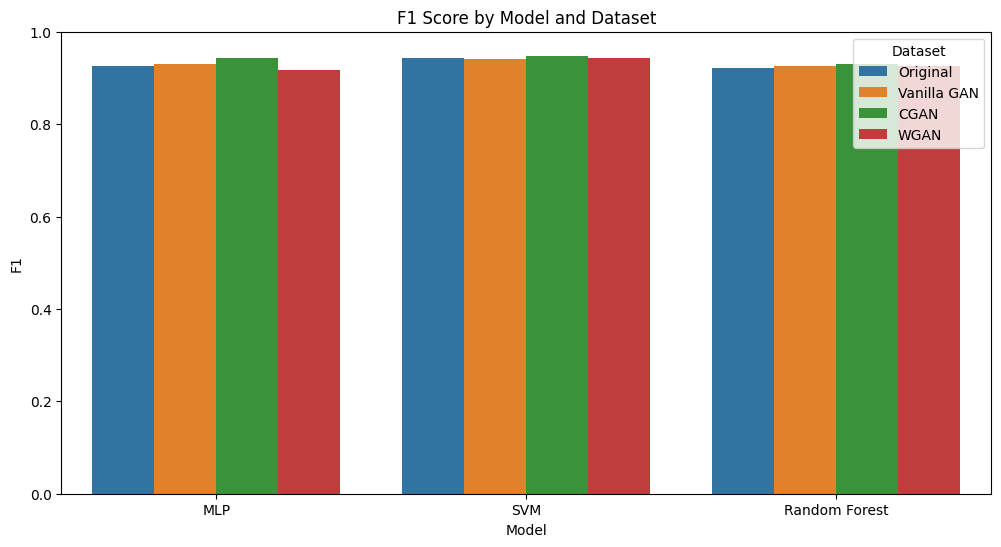

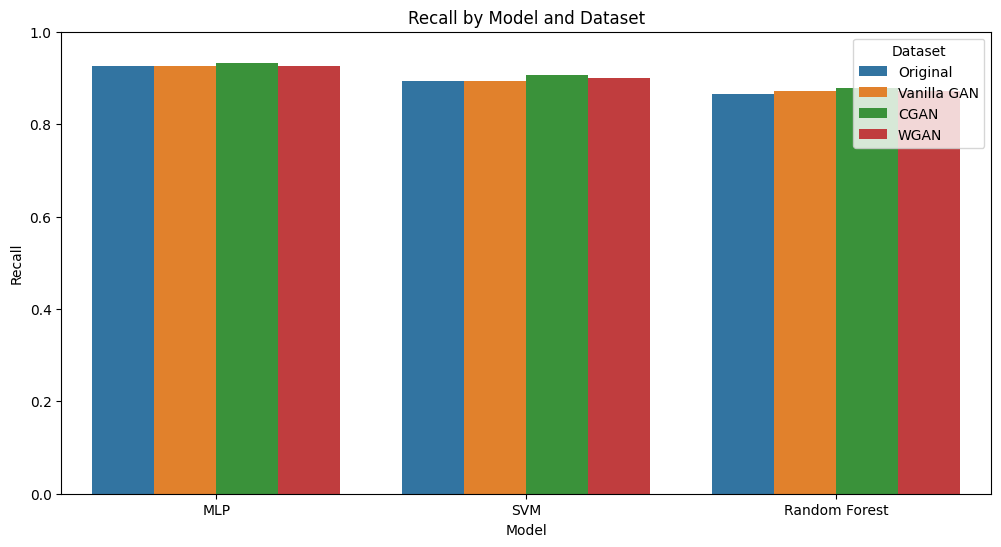

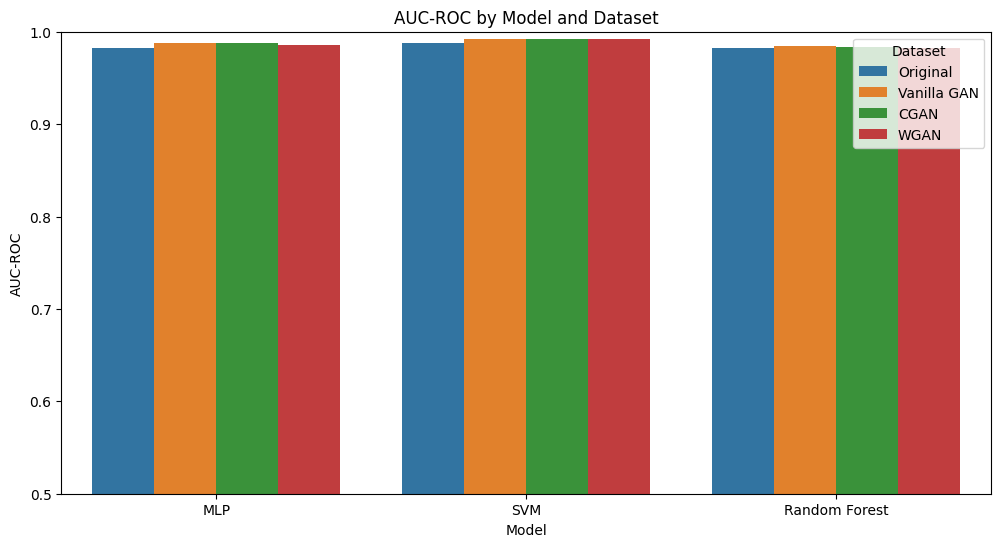

In [ ]:
# Cell 1: Install and import required libraries
!pip install transformers datasets scikit-learn matplotlib seaborn --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import random
import os
from google.colab import drive

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cell 2: Load and explore the SMS Spam Collection dataset
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Cell 3: Visualize class imbalance
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

# Cell 4: Preprocess text and split data
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(df['message']).toarray()

pca = PCA(n_components=100)
X = pca.fit_transform(X_tfidf)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_spam = X_train[y_train == 1]

# Cell 5: Define custom Dataset class for GAN training
class SpamDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

spam_dataset = SpamDataset(X_train_spam)
spam_loader = DataLoader(spam_dataset, batch_size=32, shuffle=True)

# Cell 6: Define Vanilla GAN model
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Cell 7: Train Vanilla GAN
def train_gan(generator, discriminator, dataloader, z_dim, epochs=50):
    criterion = nn.BCELoss()
    g_opt = optim.Adam(generator.parameters(), lr=0.0002)
    d_opt = optim.Adam(discriminator.parameters(), lr=0.0002)

    for epoch in range(epochs):
        for real_samples in dataloader:
            real_samples = real_samples.to(device)
            batch_size = real_samples.size(0)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            d_opt.zero_grad()
            outputs = discriminator(real_samples)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, z_dim).to(device)
            fake_samples = generator(z)
            outputs = discriminator(fake_samples.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_opt.step()

            g_opt.zero_grad()
            outputs = discriminator(fake_samples)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    return generator

# Cell 8: Initialize and train Vanilla GAN
z_dim = 100
g_vanilla = Generator(z_dim, X.shape[1]).to(device)
d_vanilla = Discriminator(X.shape[1]).to(device)

g_vanilla = train_gan(g_vanilla, d_vanilla, spam_loader, z_dim, epochs=50)

# Cell 9: Define CGAN
class CGAN_Generator(nn.Module):
    def __init__(self, z_dim, label_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        x = torch.cat([z, labels], dim=1)
        return self.net(x)

class CGAN_Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + label_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        return self.net(x)

# Cell 10: Train CGAN
def train_cgan(generator, discriminator, dataloader, z_dim, epochs=50):
    criterion = nn.BCELoss()
    g_opt = optim.Adam(generator.parameters(), lr=0.0002)
    d_opt = optim.Adam(discriminator.parameters(), lr=0.0002)

    for epoch in range(epochs):
        for real_samples in dataloader:
            real_samples = real_samples.to(device)
            batch_size = real_samples.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            d_opt.zero_grad()
            label_cond = torch.ones(batch_size, 1).to(device)
            outputs = discriminator(real_samples, label_cond)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, z_dim).to(device)
            fake_samples = generator(z, label_cond)
            outputs = discriminator(fake_samples.detach(), label_cond)
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_opt.step()

            g_opt.zero_grad()
            outputs = discriminator(fake_samples, label_cond)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_opt.step()

        if epoch % 10 == 0:
            print(f"[CGAN] Epoch {epoch}: D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    return generator

# Cell 11: Initialize and train CGAN
g_cgan = CGAN_Generator(z_dim, 1, X.shape[1]).to(device)
d_cgan = CGAN_Discriminator(X.shape[1], 1).to(device)

g_cgan = train_cgan(g_cgan, d_cgan, spam_loader, z_dim, epochs=50)

# Cell 12: Define WGAN components
class WGAN_Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

# Cell 13: Train WGAN
def train_wgan(generator, discriminator, dataloader, z_dim, epochs=50, c=0.01):
    g_opt = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    d_opt = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

    for epoch in range(epochs):
        for real_samples in dataloader:
            real_samples = real_samples.to(device)
            batch_size = real_samples.size(0)

            for _ in range(5):
                z = torch.randn(batch_size, z_dim).to(device)
                fake_samples = generator(z)

                d_opt.zero_grad()
                d_loss = -(torch.mean(discriminator(real_samples)) - torch.mean(discriminator(fake_samples.detach())))
                d_loss.backward()
                d_opt.step()

                for p in discriminator.parameters():
                    p.data.clamp_(-c, c)

            g_opt.zero_grad()
            fake_samples = generator(z)
            g_loss = -torch.mean(discriminator(fake_samples))
            g_loss.backward()
            g_opt.step()

        if epoch % 10 == 0:
            print(f"[WGAN] Epoch {epoch}: D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    return generator

# Cell 14: Initialize and train WGAN
g_wgan = Generator(z_dim, X.shape[1]).to(device)
d_wgan = WGAN_Discriminator(X.shape[1]).to(device)

g_wgan = train_wgan(g_wgan, d_wgan, spam_loader, z_dim, epochs=50)

# Cell 15: Generate synthetic samples and inverse PCA for classification
tfidf_dim = X_tfidf.shape[1]
num_synthetic = len(X_train[y_train == 0]) - len(X_train[y_train == 1])

with torch.no_grad():
    z = torch.randn(num_synthetic, z_dim).to(device)
    vanilla_samples = np.clip(g_vanilla(z).cpu().numpy(), 0, 1)
    cgan_samples = np.clip(g_cgan(z, torch.ones(num_synthetic, 1).to(device)).cpu().numpy(), 0, 1)
    wgan_samples = np.clip(g_wgan(z).cpu().numpy(), 0, 1)

# Inverse PCA to return to full TF-IDF feature space
vanilla_samples = np.clip(pca.inverse_transform(vanilla_samples), 0, 1)
cgan_samples = np.clip(pca.inverse_transform(cgan_samples), 0, 1)
wgan_samples = np.clip(pca.inverse_transform(wgan_samples), 0, 1)

X_train_tfidf = pca.inverse_transform(X_train)
X_test_tfidf = pca.inverse_transform(X_test)

# Cell 16: Create balanced datasets with synthetic samples
def create_balanced_dataset(synthetic_spam):
    X_bal = np.vstack((X_train_tfidf[y_train == 0], X_train_tfidf[y_train == 1], synthetic_spam))
    y_bal = np.hstack((y_train[y_train == 0], y_train[y_train == 1], np.ones(len(synthetic_spam))))
    return X_bal, y_bal

X_vanilla, y_vanilla = create_balanced_dataset(vanilla_samples)
X_cgan, y_cgan = create_balanced_dataset(cgan_samples)
X_wgan, y_wgan = create_balanced_dataset(wgan_samples)

# Cell 17: Define training and evaluation function for classifiers
def train_and_evaluate(X_train, y_train, X_test, y_test):
    classifiers = {
        'MLP': MLPClassifier(max_iter=300, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42)
    }

    results = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        results[name] = {
            'F1': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'AUC-ROC': roc_auc_score(y_test, y_prob),
            'Confusion Matrix': confusion_matrix(y_test, y_pred)
        }

    return results

# Cell 18: Evaluate all datasets
results_original = train_and_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test)
results_vanilla = train_and_evaluate(X_vanilla, y_vanilla, X_test_tfidf, y_test)
results_cgan = train_and_evaluate(X_cgan, y_cgan, X_test_tfidf, y_test)
results_wgan = train_and_evaluate(X_wgan, y_wgan, X_test_tfidf, y_test)

# Cell 19: Display evaluation metrics
import pprint
print("Original Dataset Results:")
pprint.pprint(results_original)

print("\nVanilla GAN Augmented Results:")
pprint.pprint(results_vanilla)

print("\nCGAN Augmented Results:")
pprint.pprint(results_cgan)

print("\nWGAN Augmented Results:")
pprint.pprint(results_wgan)

# Cell 20: Plot confusion matrices
for label, results in zip([
    'Original', 'Vanilla GAN', 'CGAN', 'WGAN'
], [
    results_original, results_vanilla, results_cgan, results_wgan
]):
    print(f"\nConfusion Matrices for {label} Dataset")
    for model, metrics in results.items():
        print(f"\n{model}:")
        ConfusionMatrixDisplay(metrics['Confusion Matrix']).plot()
        plt.title(f"{label} - {model}")
        plt.show()

# Cell 21: Visualize real and synthetic spam with t-SNE
import matplotlib.pyplot as plt

def visualize_tsne(real, synthetic, title):
    X_combined = np.vstack((real, synthetic))
    y_combined = np.array([0] * len(real) + [1] * len(synthetic))

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_2d = tsne.fit_transform(X_combined)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_combined, palette=['blue', 'red'], alpha=0.6)
    plt.title(title)
    plt.legend(labels=['Real Spam', 'Synthetic Spam'])
    plt.show()

# Example usage:
visualize_tsne(X_train_tfidf[y_train == 1], vanilla_samples, "Vanilla GAN vs Real Spam")
visualize_tsne(X_train_tfidf[y_train == 1], cgan_samples, "CGAN vs Real Spam")
visualize_tsne(X_train_tfidf[y_train == 1], wgan_samples, "WGAN vs Real Spam")

# Cell 22: Create summary DataFrame for comparison
import pandas as pd

def build_summary(results_dict, label):
    data = []
    for model_name, metrics in results_dict.items():
        data.append({
            "Dataset": label,
            "Model": model_name,
            "F1": metrics["F1"],
            "Recall": metrics["Recall"],
            "AUC-ROC": metrics["AUC-ROC"]
        })
    return pd.DataFrame(data)

summary_df = pd.concat([
    build_summary(results_original, "Original"),
    build_summary(results_vanilla, "Vanilla GAN"),
    build_summary(results_cgan, "CGAN"),
    build_summary(results_wgan, "WGAN")
], ignore_index=True)

print("\nSummary Table of Model Performance:")
print(summary_df)

# Cell 23: Plot grouped bar chart for visual comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Model", y="F1", hue="Dataset")
plt.title("F1 Score by Model and Dataset")
plt.ylim(0, 1)
plt.legend(title="Dataset")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Model", y="Recall", hue="Dataset")
plt.title("Recall by Model and Dataset")
plt.ylim(0, 1)
plt.legend(title="Dataset")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Model", y="AUC-ROC", hue="Dataset")
plt.title("AUC-ROC by Model and Dataset")
plt.ylim(0.5, 1)
plt.legend(title="Dataset")
plt.show()


